In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 1 / 30.

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,10,0,0,-0.087757,-0.057978
1,11,0,0,-0.962164,-0.843043
2,10,1,0,-0.088559,-0.058508
3,11,1,4,-1.608512,-1.938169
4,10,2,0,-0.085418,-0.056433


In [4]:
gpm.Xframe.head()

,X0
0,0
1,0
2,0
3,0
4,0


# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1]
T, K = xi.shape
print xi.shape

(512644, 5)


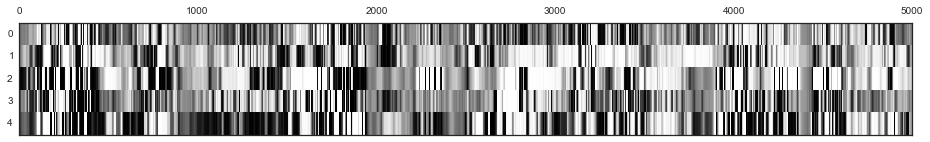

In [6]:
matshow(xi[:5000].T, vmin=0, vmax=1);

Make $\xi$ dataframe:

In [7]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

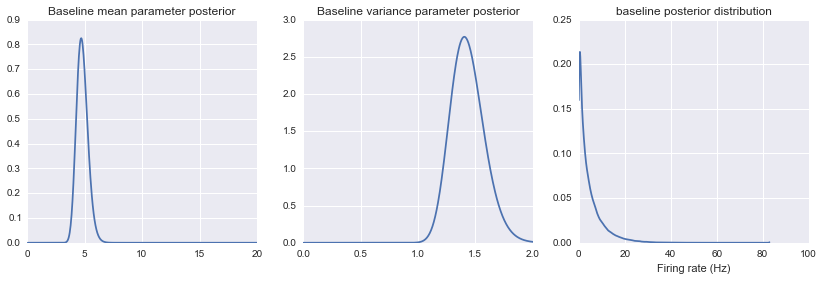

In [8]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

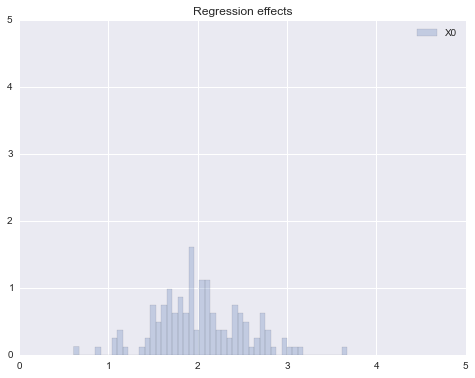

In [9]:
plt.figure(figsize=(8, 6))
inferred_means = gpm.nodes['fr_regressors'].expected_x()
R = inferred_means.shape[1]
for r in xrange(R):
    plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
plt.title('Regression effects');
plt.legend()
plt.ylim(0, 5);
plt.xlim(0, 5);

## Latent Categories

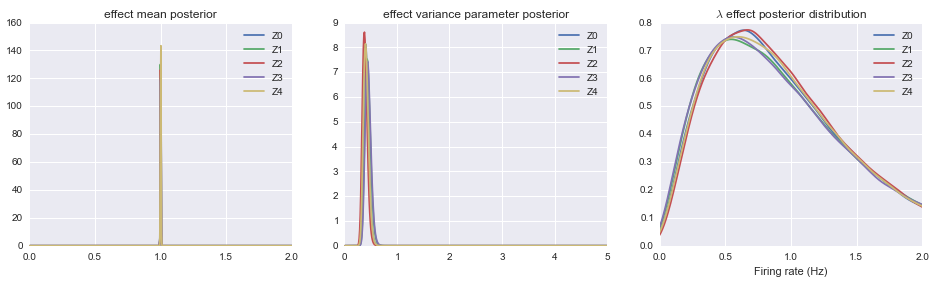

In [10]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 2);

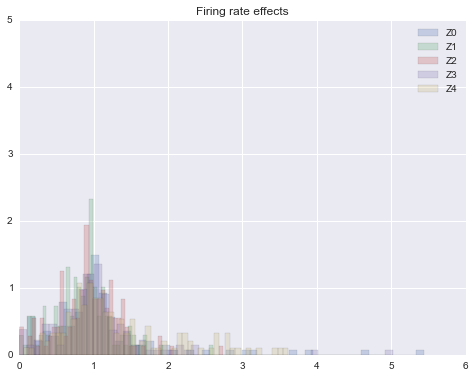

In [11]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

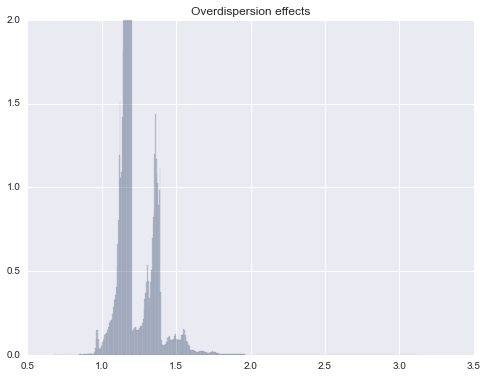

In [12]:
plt.figure(figsize=(8, 6))

inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
plt.title('Overdispersion effects');
plt.ylim(0, 2);

# Load and prepare ethogram:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [13]:
ethofile = 'sql/etho.csv'
etho = pd.read_csv(ethofile)

/Users/jmxp/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [14]:
# rename some columns
etho = etho.rename(columns={'movieId': 'movie', 'frameNumber': 'frame'})
etho = frames_to_times(etho)

In [15]:
etho.head()

,frameTime,ethoCameraLabel,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoRoughCountLabel,...,ethoChase,ethoFlee,ethoThreaten,ethoMountedThreaten,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,time
0,0.0000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0667,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0.1000,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0.1333,holding,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [16]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(etho, xif, how='right')
edf.columns

Index([u'frameTime', u'ethoCameraLabel', u'ethoCameraLevel', u'ethoCameraHolding', u'ethoCameraZoomingIn', u'ethoCameraZoomingOut', u'ethoCameraTracking', u'ethoCameraPanning', u'ethoCameraSlewing', u'ethoRoughCountLabel', u'ethoRoughCountLevel', u'ethoCountNone', u'ethoLeast1', u'ethoLeast2', u'ethoLeast3', u'ethoLeast6', u'ethoLeast11', u'ethoHumanVisible', u'ethoFaceLabel', u'ethoFaceViewLevel', u'ethoFaceNone', u'ethoFaceVisible', u'ethoFaceProminent', u'ethoFaceDirect', u'ethoFaceEyeContact', u'ethoGenitalsLabel', u'ethoGenitalsViewLevel', u'ethoGenitalsNone', u'ethoGenitalsVisible', u'ethoGenitalsProminent', u'ethoGenitalsMale', u'ethoGenitalsFemale', u'ethoGenitalsBoth', u'ethoForageLabel', u'ethoForageLevel', u'ethoForage', u'ethoMassForage', u'ethoDrink', u'ethoSearch', u'ethoGraspFood', u'ethoHoldFood', u'ethoHoldInMouth', u'ethoManipulateFood', u'ethoIngestFood', u'ethoIngestFromGroom', u'ethoChew', u'ethoRetrieveFromPouch', u'ethoHeave', u'ethoAllogroom', u'ethoSolicitAllog

In [17]:
# get rid of categories that are either identifiers or have non-binary entries
edf = edf.drop(['frameTime', 'ethoCameraLabel', 'ethoFaceLabel',
                'ethoGenitalsLabel', 'ethoForageLabel', 'ethoAggressionLabel', 'time',
                'ethoRoughCountLabel', 'ethoRoughCountLevel', 'ethoFaceViewLevel', 
                'ethoGenitalsViewLevel', 'ethoForageLevel', 'ethoAggressionLevel'], axis=1)


In [18]:
edf.head()

,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,...,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,Z0,Z1,Z2,Z3,Z4
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.032431,0.030681,0.007067,0.020552,0.033363
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.105307,0.090770,0.034923,0.047004,0.062407
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.185309,0.168386,0.030690,0.139522,0.099783
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.250883,0.236472,0.027867,0.210568,0.132178
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.305391,0.296920,0.025380,0.264497,0.160218


# View results:

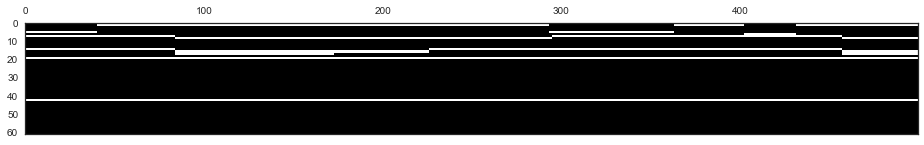

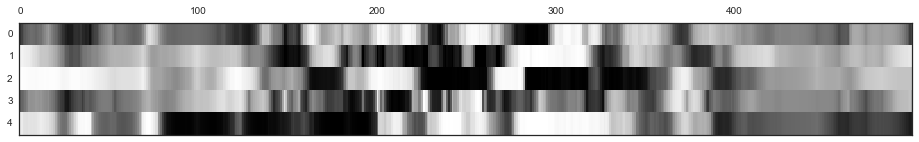

In [19]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(500, 1000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [20]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

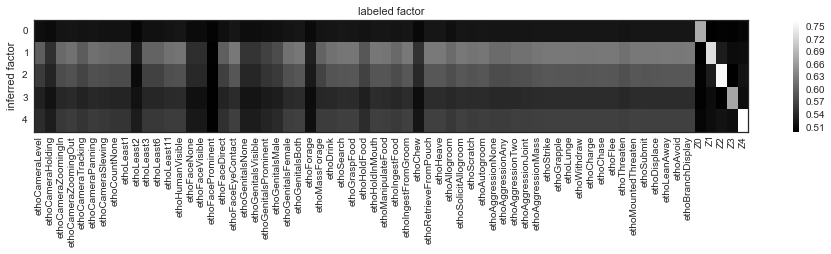

In [21]:
row_labels = edf.columns[:]
matshow(overlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [22]:
overlap.iloc[-K:, :]

,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoCountNone,ethoLeast1,ethoLeast2,...,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,Z0,Z1,Z2,Z3,Z4
Z0,0.515935,0.512729,0.522212,0.523755,0.521401,0.522692,0.520021,0.520432,0.520432,0.507245,...,0.524335,0.524199,0.524350,0.524324,0.524229,0.682492,0.500918,0.504596,0.503304,0.507644
Z1,0.599318,0.551146,0.610825,0.620777,0.597975,0.617860,0.613304,0.609538,0.609538,0.534189,...,0.626337,0.626572,0.627323,0.627204,0.627331,0.500918,0.734310,0.531093,0.514087,0.515157
Z2,0.563162,0.539368,0.580626,0.586643,0.572754,0.584736,0.583058,0.579464,0.579464,0.513177,...,0.590610,0.591358,0.592014,0.592103,0.591984,0.504596,0.531093,0.760900,0.501764,0.520881
Z3,0.534901,0.520467,0.541828,0.545484,0.536922,0.544622,0.541607,0.539915,0.539915,0.520611,...,0.547570,0.547140,0.547502,0.547472,0.547359,0.503304,0.514087,0.501764,0.673197,0.516352
Z4,0.547226,0.531719,0.561349,0.565522,0.556079,0.563020,0.559964,0.557095,0.557095,0.530413,...,0.568183,0.568508,0.568489,0.568342,0.568612,0.507644,0.515157,0.520881,0.516352,0.768161
